### Install packages

In [ ]:
!pip -q install efficientnet_pytorch
!pip -q install audiomentations
!pip install ../input/torchlibrosa/torchlibrosa-0.0.5-py3-none-any.whl

### import packages

In [ ]:
import os, sys, glob, random, time, cv2

sys.path.append('../input/pytorchimagemodels')
sys.path.append('../input/kagglebirdcall')

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display
import soundfile as sf

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from functools import partial
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from transformers import get_linear_schedule_with_warmup

from skimage.transform import resize
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import exposure

from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation

import timm
from timm.models import efficientnet as eff
from src.models import PANNsCNN14Att, ResNestSED, EfficientNetSED

### About Sound Event Detection(SED)

Sound event detection (SED) is the task of detecting the type as well as
the onset and offset times of sound events in audio streams.

In this notebook i will show how to train Sound Event Detection (SED) model with only weak annotation.

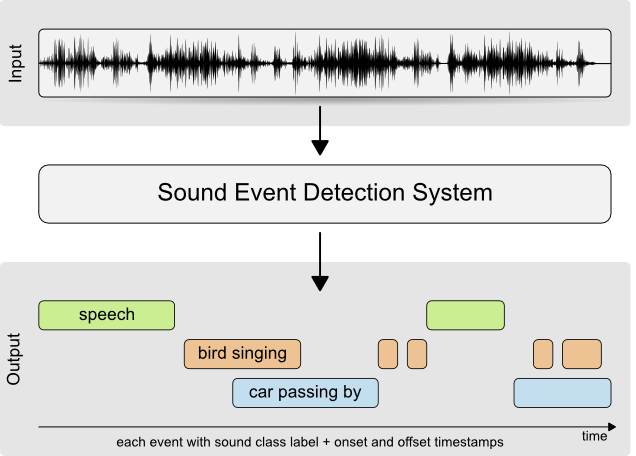

In SED task, we need to detect sound events from continuous (long) audio clip, and provide prediction of what sound event exists from when to when.

for more details

-> [Polyphonic Sound Event Detection
with Weak Labeling Paper](http://www.cs.cmu.edu/~yunwang/papers/cmu-thesis.pdf)

-> [Introduction to Sound Event Detection Notebook](https://www.kaggle.com/hidehisaarai1213/introduction-to-sound-event-detection)


### Config

In [ ]:
SAMPLE_RATE = 32000

class args:
    DEBUG = False

    model_tag = "SEDE_efficientnet_b0"  # SEDR_resnest50_fast_4s2x40d
    pretrain_weights = None
    model_param = {
        'num_classes': 397,
        'pretrained': True
    }
    melspectrogram_parameters = {
        'sample_rate': SAMPLE_RATE,
        'n_fft': int(SAMPLE_RATE/10),
        'hop_length': int(SAMPLE_RATE/(10*4)),
        'n_mels': 128,
        'fmin': 0, 
        'fmax': SAMPLE_RATE/2
    }
    pcen_parameters = {
        "gain": 0.98,
        "bias": 2,
        "power": 0.5,
        "time_constant": 0.4,
        "eps": 0.000001
    }
    img_size = (128, 281)
    period = 7
    seed = 42
    folds = 5
    start_epoch = 0 
    epochs = 40
    lr = 1e-3
    batch_size = 16
    num_workers = 4
    early_stop = 10
    step_scheduler = True
    epoch_scheduler = False

    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    train_csv = "../input/kkiller-birdclef-2021/rich_train_metadata.csv"
    test_csv = "../input/birdclef-2021/test.csv"
    sub_csv = "../input/birdclef-2021/sample_submission.csv"
    output_dir = "weights"
    train_data_path = "../input/birdclef-2021/train_short_audio"
    test_data_path = "../input/birdclef-2021/test_soundscapes"

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(args.seed)

### Create Folds

In [ ]:
train = pd.read_csv("../input/birdclef-2021/train_metadata.csv").sort_values("filename")
sub = pd.read_csv(args.sub_csv)

# train_gby = train.groupby("filename")[["primary_label"]].first().reset_index()
# train_gby = train_gby.sample(frac=1, random_state=args.seed).reset_index(drop=True)
# train_gby.loc[:, 'fold'] = -1

# X = train_gby["filename"].values
# y = train_gby["primary_label"].values

# kfold = StratifiedKFold(n_splits=args.folds)
# for fold, (t_idx, v_idx) in enumerate(kfold.split(X, y)):
#     train_gby.loc[v_idx, "fold"] = fold

# train = train.merge(train_gby[['filename', 'fold']], on="filename", how="left")
# print(train.fold.value_counts())
# train.to_csv('rich_train_metadata.csv', index=False)

In [ ]:
LABEL_IDS = {label: label_id for label_id, label in enumerate(sorted(train["primary_label"].unique()))}
INV_LABEL_IDS = {val: key for key,val in LABEL_IDS.items()}

### SED Model

1. Model takes raw waveform and converted into log-melspectogram using `torchlibrosa`'s module
2. spectogram converted into 3-channels input for ImageNet pretrain model to extract features from CNN's
3. Although it's downsized through several convolution and pooling layers, the size of it's third dimension and it still contains time information. Each element of this dimension is segment. In SED model, we provide prediction for each of this.

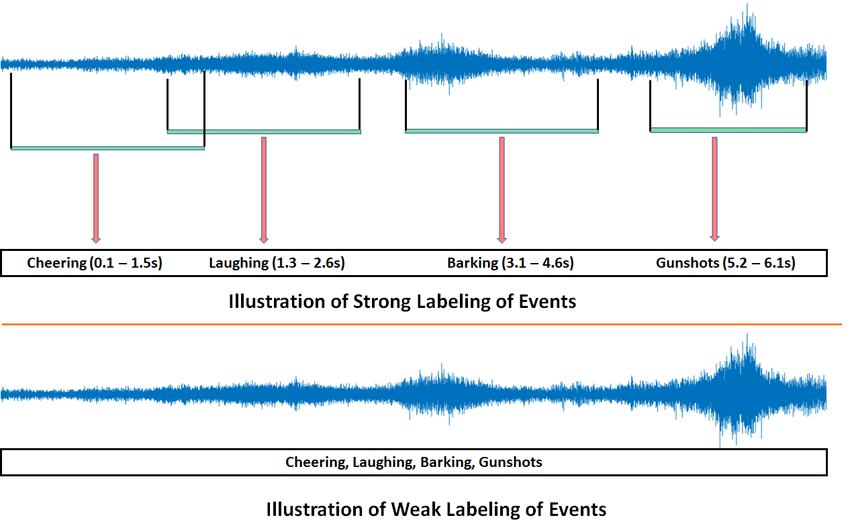

4. This figure gives us an intuitive explanation what is weak annotation and what is strong annotation in terms of sound event detection. For this competition, we only have weak annotation (clip level annotation). Therefore, we need to train our SED model in weakly-supervised manner.

5. In weakly-supervised setting, we only have clip-level annotation, therefore we also need to aggregate that in time axis. Hense, we at first put classifier that outputs class existence probability for each time step just after the feature extractor and then aggregate the output of the classifier result in time axis. In this way we can get both clip-level prediction and segment-level prediction (if the time resolution is high, it can be treated as event-level prediction). Then we train it normally by using BCE loss with clip-level prediction and clip-level annotation.

In [ ]:
encoder_params = {
    "SEDR_resnest50": {
        "base_model_name": 'resnest50',  # resnest200
    },
    "SEDR_resnest50_fast_1s1x64d": {
        "base_model_name": 'resnest50_fast_1s1x64d',
    },
    "SEDR_resnest50_fast_4s2x40d": {
        "base_model_name": 'resnest50_fast_4s2x40d',
    },
    "SEDR_resnest50_fast_1s4x24d": {
        "base_model_name": 'resnest50_fast_1s4x24d',
    },
    "SEDE_efficientnet_b0": {
        "base_model_name": 'efficientnet-b0',
    },
    "SED_PANNsCNN14Att": {
        "base_model_name": 'PANNsCNN14Att',
    },
    "tf_efficientnet_b0": {
        "base_model_name": 'tf_efficientnet_b0',
        "features": 1280,
        "init_op": partial(eff.tf_efficientnet_b0, pretrained=True, in_chans=1)
    },
    "resnet50" : {
        "base_model_name": 'resnet50',
        "features" : 2048,
        "init_op"  : partial(timm.models.resnet50, pretrained=True, in_chans=1)
    },
    "resnet200d" : {
        "base_model_name": 'resnet200d',
        "features" : 2048,
        "init_op"  : partial(timm.models.resnet200d, pretrained=True, in_chans=1)
    },
    "wide_resnet50_2" : {
        "base_model_name": 'wide_resnet50_2',
        "features" : 2048,
        "init_op"  : partial(timm.models.wide_resnet50_2, pretrained=True, in_chans=1)
    },
    "inception_resnet_v2" : {
        "base_model_name": 'inception_resnet_v2',
        "features": 1536,
        "init_op": partial(timm.models.inception_resnet_v2, pretrained=True, in_chans=1)
    },
    "efficientnet_b3": {
        "base_model_name": 'efficientnet_b3',
        "features": 1536,
        "init_op": partial(timm.models.efficientnet_b3, pretrained=True, in_chans=1)
    },
    "resnest50d" : {
        "base_model_name": 'resnest50d',
        "features" : 2048,
        "init_op"  : partial(timm.models.resnest50d, pretrained=True, in_chans=1)
    },
    "densenet201" : {
        "base_model_name": 'densenet201',
        "features": 1920,
        "init_op": partial(timm.models.densenet201, pretrained=True)
    },
    "dpn92" : {
        "base_model_name": 'dpn92',
        "features": 2688,
        "init_op": partial(timm.models.dpn92, pretrained=True)
    },
    "dpn131": {
        "base_model_name": 'dpn131',
        "features": 2688,
        "init_op": partial(timm.models.dpn131, pretrained=True)
    },
    "tf_efficientnet_b0_ns": {
        "base_model_name": 'tf_efficientnet_b0_ns',
        "features": 1280,
        "init_op": partial(eff.tf_efficientnet_b0_ns, pretrained=True, drop_path_rate=0.2, in_chans=1)
    },
    "tf_efficientnet_b3_ns": {
        "base_model_name": 'tf_efficientnet_b3_ns',
        "features": 1536,
        "init_op": partial(eff.tf_efficientnet_b3_ns, pretrained=True, drop_path_rate=0.2, in_chans=1)
    },
    "tf_efficientnet_b2_ns": {
        "base_model_name": 'tf_efficientnet_b2_ns',
        "features": 1408,
        "init_op": partial(eff.tf_efficientnet_b2_ns, pretrained=True, drop_path_rate=0.2, in_chans=1)
    },
    "tf_efficientnet_b4_ns": {
        "base_model_name": 'tf_efficientnet_b4_ns',
        "features": 1792,
        "init_op": partial(eff.tf_efficientnet_b4_ns, pretrained=True, drop_path_rate=0.2, in_chans=1)
    },
    "tf_efficientnet_b5_ns": {
        "base_model_name": 'tf_efficientnet_b5_ns',
        "features": 2048,
        "init_op": partial(eff.tf_efficientnet_b5_ns, pretrained=True, drop_path_rate=0.2, in_chans=1)
    },
    "tf_efficientnet_b6_ns": {
        "base_model_name": 'tf_efficientnet_b6_ns',
        "features": 2304,
        "init_op": partial(eff.tf_efficientnet_b6_ns, pretrained=True, drop_path_rate=0.2, in_chans=1)
    },
}

In [ ]:
class AudioClassifier(nn.Module):
    def __init__(self, encoder, sample_rate, n_fft, hop_length, n_mels, fmin, fmax, classes_num):
        super().__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(n_fft=n_fft, hop_length=hop_length, 
            win_length=n_fft, window=window, center=center, pad_mode=pad_mode, 
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=n_fft, 
            n_mels=n_mels, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
            freq_drop_width=8, freq_stripes_num=2)
        
        self.encoder = encoder_params[encoder]["init_op"]()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(encoder_params[encoder]['features'], classes_num)

    def do_mixup(self, x, mixup_lambda):
        """Mixup x of even indexes (0, 2, 4, ...) with x of odd indexes 
        (1, 3, 5, ...).

        Args:
          x: (batch_size * 2, ...)
          mixup_lambda: (batch_size * 2,)

        Returns:
          out: (batch_size, ...)
        """
        out = (x[0 :: 2].transpose(0, -1) * mixup_lambda[0 :: 2] + \
            x[1 :: 2].transpose(0, -1) * mixup_lambda[1 :: 2]).transpose(0, -1)
        return out
    
    def forward(self, input, spec_aug=True, mixup_lambda=None):
        x = self.spectrogram_extractor(input.float()) # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x) # (batch_size, 1, time_steps, mel_bins)

        if spec_aug:
            x = self.spec_augmenter(x)
        
        # Mixup on spectrogram
        if mixup_lambda is not None:
            x = self.do_mixup(x, mixup_lambda)
            #pass
        x = self.encoder.forward_features(x)
        x = self.avg_pool(x).flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

### Dataset

In [ ]:
def addNoisy(img):
    return random_noise(img)

def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    return exposure.rescale_intensity(img, in_range=(p2, p98))

def randomGaussian(img):
    return gaussian(img, sigma=random.randint(0, 5))

In [ ]:
def normalize_melspec(X: np.ndarray, shape=None):
    eps = 1e-6
    mean = X.mean()
    X = X - mean
    std = X.std()
    Xstd = X / (std + eps)
    norm_min, norm_max = Xstd.min(), Xstd.max()
    if (norm_max - norm_min) > eps:
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)

    if shape:
        V = resize(V, shape)
    return V

In [ ]:
def melspect_convert(y, sr, spectrogram_transforms=None):
    args.melspectrogram_parameters.pop('sample_rate', None)
    melspec = librosa.feature.melspectrogram(y, sr=sr, **args.melspectrogram_parameters)
    pcen = librosa.pcen(melspec, sr=sr, **args.pcen_parameters)
    clean_mel = librosa.power_to_db(melspec ** 1.5)
    melspec = librosa.power_to_db(melspec)

    if spectrogram_transforms:
        melspec = spectrogram_transforms(image=melspec)["image"]
        pcen = spectrogram_transforms(image=pcen)["image"]
        clean_mel = spectrogram_transforms(image=clean_mel)["image"]
    else:
        pass

    norm_melspec = normalize_melspec(melspec, args.img_size)
#     norm_pcen = normalize_melspec(pcen, args.img_size)
#     norm_clean_mel = normalize_melspec(clean_mel, args.img_size)

#     for fun in [addNoisy, contrast_stretching, randomGaussian]:
#         if np.random.rand() < 0.3:
#             norm_melspec = fun(norm_melspec)
#             norm_pcen = fun(norm_pcen)
#             norm_clean_mel = fun(norm_clean_mel)

#     image = np.stack((norm_melspec, norm_pcen, norm_clean_mel))
    image = np.stack((norm_melspec, norm_melspec, norm_melspec))
    
#     mfcc = librosa.feature.mfcc(y, sr=sr,
#                                  n_mfcc=args.melspectrogram_parameters['n_mels'],
#                                  hop_length=args.melspectrogram_parameters['hop_length'],
#                                  n_fft=args.melspectrogram_parameters['n_fft'])

#     spec_bandwidth = librosa.feature.spectral_bandwidth(y, sr=sr)
#     chroma_stft = librosa.feature.chroma_stft(y, sr=sr)
#     spec_centroid = librosa.feature.spectral_centroid(y, sr=sr)
#     spectral_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)
    
#     N = mfcc.shape[1]
#     extra_feature = np.array([spectral_rolloff]).reshape(1, N)
#     extra_feature = np.append(extra_feature, spectral_rolloff.reshape(1, N), axis=0)
#     for i in range(0, 9):
#             extra_feature = np.append(extra_feature, spec_bandwidth.reshape(1, N), axis=0)
#             extra_feature = np.append(extra_feature, spec_centroid.reshape(1, N), axis=0)
#             extra_feature = np.append(extra_feature, chroma_stft.reshape(12, N), axis=0)
#     image = np.stack((norm_melspec, normalize_melspec(mfcc, args.img_size), normalize_melspec(extra_feature, args.img_size)))
    return (image / 255.0).astype(np.float32)

In [ ]:
class SedDataset:
    def __init__(self, df, period=7, stride=7, audio_transform=None, mels_transform=None, data_path="train", mode="train"):
        self.period = period
        self.stride = stride
        self.audio_transform = audio_transform
        self.mels_transform = mels_transform
        self.data_path = data_path
        self.mode = mode

        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        
        FLAG_IMAGE = True
        
        if FLAG_IMAGE and (args.model_tag.startswith("SEDR_") or args.model_tag.startswith("SEDE_")):
            images = np.load(f"../input/kkiller-birdclef-2021/audio_images/{record['primary_label']}/{record['filename']}.npy")
            melspec = images[np.random.randint(images.shape[0]), :, :]
            norm_melspec = normalize_melspec(melspec, args.img_size)
            image = np.stack((norm_melspec, norm_melspec, norm_melspec))
            y = (image / 255.0).astype(np.float32)
        else:
            y, orig_sr = sf.read(f"{self.data_path}/{record['primary_label']}/{record['filename']}", dtype="float32")
            if orig_sr != SAMPLE_RATE:
                y = librosa.resample(y, orig_sr, SAMPLE_RATE, res_type='kaiser_fast')

            len_y = len(y)
            effective_length = SAMPLE_RATE * self.period
            stride = self.stride * SAMPLE_RATE

    #         if args.model_tag.startswith("SEDR_") or args.model_tag.startswith("SEDE_"):
    #             y = np.stack([melspect_convert(y[i:i+effective_length], sr, self.mels_transform).astype(np.float32) for i in range(0, len(y)+stride-effective_length, stride)])
    #         else:
    #             y = np.stack([y[i:i+effective_length].astype(np.float32) for i in range(0, len(y)+stride-effective_length, stride)])

            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                if self.mode != "test":
                    start = np.random.randint(effective_length - len_y)
                else:
                    start = 0
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                if self.mode != "test":
                    start = np.random.randint(len_y - effective_length)
                else:
                    start = 0
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)
            y = np.nan_to_num(y)
            if self.audio_transform:
                y = self.audio_transform(samples=y, sample_rate=SAMPLE_RATE)
            y = np.nan_to_num(y)
            if args.model_tag.startswith("SEDR_") or args.model_tag.startswith("SEDE_"):
                y = melspect_convert(y, SAMPLE_RATE, self.mels_transform)

        label = np.zeros(args.model_param['num_classes'], dtype='f')
        label[LABEL_IDS[record['primary_label']]] = 1.0

        return {
            "image" : y,
            "target" : label,
#             "id" : record['row_id']
        }

### Augmentations

In [ ]:
import audiomentations as AA

train_audio_transform = AA.Compose([
#     AA.AddGaussianNoise(p=0.5),
#     AA.AddGaussianSNR(p=0.5),
#     AA.AddBackgroundNoise("../input/train_audio/", p=1)
#     AA.AddImpulseResponse(p=0.1),
#     AA.AddShortNoises("../input/train_audio/", p=1)
#     AA.FrequencyMask(min_frequency_band=0.0,  max_frequency_band=0.2, p=0.1),
#     AA.TimeMask(min_band_part=0.0, max_band_part=0.2, p=0.1),
#     AA.PitchShift(min_semitones=-0.5, max_semitones=0.5, p=0.1),
#     AA.Shift(p=0.1),
#     AA.Normalize(p=0.1),
#     AA.ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=1, p=0.05),
#     AA.PolarityInversion(p=0.05),
#     AA.Gain(p=0.2)
])

### Utils

In [ ]:
def f1_score(o, y):
    acc = (o==y).float().mean()
    prec = (o*y).sum()/(1e-6 + o.sum())
    rec = (o*y).sum()/(1e-6 + y.sum())
    f1 = 2*prec*rec/(1e-6 + prec + rec)
    return f1

def calc_metrics(y_true: np.ndarray, y_pred: np.ndarray, threshold=0.5):
    mAP = metrics.average_precision_score(y_true, y_pred, average=None)
    mAP = np.nan_to_num(mAP).mean()

    classwise_f1s = []
    for i in range(len(y_true[0])):
        class_i_pred = y_pred[:, i] > threshold
        class_i_targ = y_true[:, i]
        if class_i_targ.sum() == 0 and class_i_pred.sum() == 0:
            classwise_f1s.append(1.0)
        else:
            classwise_f1s.append(metrics.f1_score(y_true=class_i_targ, y_pred=class_i_pred))

    classwise_f1 = np.mean(classwise_f1s)

    y_pred_thresholded = (y_pred > threshold).astype(int)
    sample_f1 = metrics.f1_score(y_true=y_true, y_pred=y_pred_thresholded, average="samples")
    return mAP, classwise_f1, sample_f1

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class MetricMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.y_true = []
        self.y_pred = []
    
    def update(self, y_true, y_pred):
        self.y_true.extend(y_true.cpu().detach().numpy().tolist())
        self.y_pred.extend(y_pred.cpu().detach().numpy().tolist())

    @property
    def avg(self):
        self.mAP, self.classwise_f1, self.sample_f1 = calc_metrics(np.array(self.y_true), np.array(self.y_pred))
        return {
            "mAP": self.mAP,
            "sample_f1": self.sample_f1,
        }

### Losses

In [ ]:
# https://www.kaggle.com/c/rfcx-species-audio-detection/discussion/213075
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(preds, targets)
        probas = torch.sigmoid(preds)
        loss = targets * self.alpha * \
            (1. - probas)**self.gamma * bce_loss + \
            (1. - targets) * probas**self.gamma * bce_loss
        loss = loss.mean()
        return loss


class BCEFocal2WayLoss(nn.Module):
    def __init__(self, weights=[1, 1], class_weights=None):
        super().__init__()

        self.focal = BCEFocalLoss()

        self.weights = weights

    def forward(self, input, target):
        input_ = input["logit"]
        target = target.float()

        framewise_output = input["framewise_logit"]
        clipwise_output_with_max, _ = framewise_output.max(dim=1)

        loss = self.focal(input_, target)
        aux_loss = self.focal(clipwise_output_with_max, target)

        return self.weights[0] * loss + self.weights[1] * aux_loss

### Functions

In [ ]:
def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    losses = AverageMeter()
    scores = MetricMeter()

    model.train()
    t = tqdm(loader)
    for i, sample in enumerate(t):
        optimizer.zero_grad()
        input = sample['image'].to(args.device)
        target = sample['target'].to(args.device)
        output = model(input)
        if args.model_tag.startswith("SED"):
            loss = criterion(output, target)
        else:
            loss = criterion(torch.sigmoid(output), target)
        loss.backward()
        optimizer.step()
        if scheduler and args.step_scheduler:
            scheduler.step()

        bs = input.size(0)
        if args.model_tag.startswith("SED"):
            # output = torch.max(output['framewise_output'], dim=1)[0]
            output = output
            scores.update(target, output['clipwise_output'])
        else:
            output = torch.sigmoid(output)
            scores.update(target, output)
        losses.update(loss.item(), bs)

        t.set_description(f"Train E:{epoch} - Loss{losses.avg:0.4f}")
    t.close()
    return scores.avg, losses.avg
        
def valid_epoch(args, model, loader, criterion, epoch):
    losses = AverageMeter()
    scores = MetricMeter()
    model.eval()
    with torch.no_grad():
        t = tqdm(loader)
        for i, sample in enumerate(t):
            input = sample['image'].to(args.device)
            target = sample['target'].to(args.device)
            output = model(input)
            if args.model_tag.startswith("SED"):
                # output = torch.max(output['framewise_output'], dim=1)[0]
                output = output
                scores.update(target, output['clipwise_output'])
            else:
                output = torch.sigmoid(output)
                scores.update(target, output)
            loss = criterion(output, target)

            bs = input.size(0)
            losses.update(loss.item(), bs)
            t.set_description(f"Valid E:{epoch} - Loss:{losses.avg:0.4f}")
    t.close()
    return scores.avg, losses.avg

def test_epoch(args, model, loader):
    model.eval()
    pred_list = []
    id_list = []
    with torch.no_grad():
        t = tqdm(loader)
        for i, sample in enumerate(t):
            input = sample["image"].to(args.device)
            if args.model_tag.startswith("SEDR_") or args.model_tag.startswith("SEDE_"):
                bs, seq, c, w, h = input.shape
                input = input.reshape(bs*seq, c, w, h)
            else:
                bs, seq, w = input.shape
                input = input.reshape(bs*seq, w)
            id = sample["id"]
            output = model(input)
            if args.model_tag.startswith("SED"):
                # output = torch.max(output['framewise_output'], dim=1)[0]
                output = output
            else:
                output = torch.sigmoid(output)
            output = output.reshape(bs, seq, -1)
            output = torch.sum(output, dim=1)
            #output, _ = torch.max(output, dim=1)
            output = output.cpu().detach().numpy().tolist()
            pred_list.extend(output)
            id_list.extend(id)
    
    return pred_list, id_list

### Main Function

In [ ]:
def main(fold):
    seed_everything(args.seed)

    args.fold = fold
    args.save_path = os.path.join(args.output_dir, args.model_tag)
    os.makedirs(args.save_path, exist_ok=True)

    train_df = pd.read_csv(args.train_csv)
    sub_df = pd.read_csv(args.sub_csv)
    if args.DEBUG:
        train_df = train_df.sample(200)
    train_fold = train_df[train_df.fold != fold]
    valid_fold = train_df[train_df.fold == fold]

    train_dataset = SedDataset(
        df = train_fold,
        period=args.period,
        audio_transform=train_audio_transform,
        data_path=args.train_data_path,
        mode="train"
    )

    valid_dataset = SedDataset(
        df = valid_fold,
        period=args.period,
        stride=args.period,
        audio_transform=None,
        data_path=args.train_data_path,
        mode="valid"
    )

#     test_dataset = SedDataset(
#         df = sub_df,
#         period=args.period,
#         stride=args.period,
#         audio_transform=None,
#         data_path=args.test_data_path,
#         mode="test"
#     )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.num_workers
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=args.num_workers
    )

#     test_loader = torch.utils.data.DataLoader(
#         test_dataset,
#         batch_size=int(args.batch_size/2),
#         shuffle=False,
#         drop_last=False,
#         num_workers=args.num_workers
#     )

    if args.model_tag.startswith("SEDR_"):
        args.model_param['base_model_name'] = encoder_params[args.model_tag]['base_model_name']
        model = ResNestSED(**args.model_param)
    elif args.model_tag.startswith("SEDE_"):
        args.model_param['base_model_name'] = encoder_params[args.model_tag]['base_model_name']
        model = EfficientNetSED(**args.model_param)
    elif args.model_tag.startswith("SED"):
        args.melspectrogram_parameters['classes_num'] = args.model_param['num_classes']
        args.melspectrogram_parameters['window_size'] = args.melspectrogram_parameters['n_fft']
        args.melspectrogram_parameters.pop('n_fft', None)
        args.melspectrogram_parameters['hop_size'] = args.melspectrogram_parameters['hop_length']
        args.melspectrogram_parameters.pop('hop_length', None)
        args.melspectrogram_parameters['mel_bins'] = args.melspectrogram_parameters['n_mels']
        args.melspectrogram_parameters.pop('n_mels', None)
        model = PANNsCNN14Att(**args.melspectrogram_parameters)
    else:
        args.melspectrogram_parameters['classes_num'] = args.model_param['num_classes']
        args.melspectrogram_parameters['encoder'] = encoder_params[args.model_tag]['base_model_name']
        model = AudioClassifier(**args.melspectrogram_parameters)

    model = model.to(args.device)

    if args.pretrain_weights:
        print("---------------------loading pretrain weights")
        model.load_state_dict(torch.load(args.pretrain_weights, map_location=args.device), strict=False)
        model = model.to(args.device)

    criterion = BCEFocal2WayLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-6)
    num_train_steps = int(len(train_loader) * args.epochs)
    num_warmup_steps = int(0.1 * args.epochs * len(train_loader))
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)

    best_loss = np.inf
    best_sample_f1 = -np.inf
    early_stop_count = 0

    for epoch in range(args.start_epoch, args.epochs):
        train_avg, train_loss = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        valid_avg, valid_loss = valid_epoch(args, model, valid_loader, criterion, epoch)

        if args.epoch_scheduler:
            scheduler.step()

        content = f"""
                {time.ctime()} \n
                Fold:{args.fold}, Epoch:{epoch}, lr:{optimizer.param_groups[0]['lr']:.7}\n
                Train Loss:{train_loss:0.4f}-mAP:{train_avg['mAP']:0.4f}-sample_f1:{train_avg['sample_f1']:0.4f}\n
                Valid Loss:{valid_loss:0.4f}-mAP:{valid_avg['mAP']:0.4f}-sample_f1:{valid_avg['sample_f1']:0.4f}\n
        """
        print(content)
        with open(f'{args.save_path}/log_{args.model_tag}.txt', 'a') as appender:
            appender.write(content+'\n')
        
        if valid_avg['sample_f1'] > best_sample_f1:
            print(f"########## >>>>>>>> Model Improved From {best_sample_f1} ----> {valid_avg['sample_f1']}")
            torch.save(model.state_dict(), os.path.join(args.save_path, f'fold-{args.fold}.bin'))
            best_sample_f1 = valid_avg['sample_f1']
#             early_stop_count = 0
#         else:
#             early_stop_count += 1
            
        if valid_loss < best_loss:
            print(f"########## >>>>>>>> Model Improved From {best_loss} ----> {valid_loss}")
            torch.save(model.state_dict(), os.path.join(args.save_path, f'fold-{args.fold}_loss.bin'))
            best_loss = valid_loss
            early_stop_count = 0
        else:
            early_stop_count += 1
        #torch.save(model.state_dict(), os.path.join(args.save_path, f'fold-{args.fold}_last.bin'))

        if args.early_stop == early_stop_count:
            print("\n $$$ ---? Ohoo.... we reached early stoping count :", early_stop_count)
            break
    
#     model.load_state_dict(torch.load(os.path.join(args.save_path, f'fold-{args.fold}.bin'), map_location=args.device))
#     model = model.to(args.device)

#     target_cols = sub_df.columns[1:].values.tolist()
#     test_pred, ids = test_epoch(args, model, test_loader)
#     print(np.array(test_pred).shape)

#     test_pred_df = pd.DataFrame({
#         "row_id" : sub_df.row_id.values
#     })
#     test_pred_df[target_cols] = test_pred
#     test_pred_df.to_csv(os.path.join(args.save_path, f"fold-{args.fold}-submission.csv"), index=False)
#     print(os.path.join(args.save_path, f"fold-{args.fold}-submission.csv"))

### train folds

In [ ]:
main(fold=0)